In [1]:
import os.path  # Importa el módulo os.path para trabajar con rutas de archivos
import pandas as pd  # Importa la biblioteca pandas y la abrevia como pd para trabajar con datos estructurados
import datetime  # Importa el módulo datetime para trabajar con fechas y horas
import matplotlib.pyplot as plt  # Importa la biblioteca matplotlib.pyplot para trazar gráficos

wd = os.getcwd()  # Obtiene el directorio de trabajo actual
directorio = os.listdir(wd)  # Obtiene una lista de todos los archivos y directorios en el directorio actual
data = []  # Inicializa una lista vacía para almacenar los datos de los archivos CSV
for archivo in directorio:  # Itera sobre cada archivo en el directorio
    nombre, extension = os.path.splitext(archivo)  # Divide el nombre del archivo y su extensión
    if extension == '.csv':  # Verifica si la extensión del archivo es '.csv'
        data.append(pd.read_csv(archivo))  # Lee el archivo CSV y lo agrega a la lista de datos
datos_unidos = pd.concat(data)  # Combina todos los DataFrames de la lista en uno solo
datos_unidos['data'] = pd.to_datetime(datos_unidos['Fecha'])  # Convierte la columna 'Fecha' en formato datetime
nombre_estacion = datos_unidos['CodigoEstacion'].unique()  # Obtiene valores únicos de la columna 'CodigoEstacion'
latitud = datos_unidos['Latitud'].unique()  # Obtiene valores únicos de la columna 'Latitud'
longitud = datos_unidos['Longitud'].unique()  # Obtiene valores únicos de la columna 'Longitud'
datos_unidos = datos_unidos[["Fecha", "Valor", "NombreEstacion"]]  # Selecciona solo las columnas necesarias
datos_organizados = datos_unidos.pivot_table(index="Fecha",  # Crea una tabla pivot con la fecha como índice
                                             columns="NombreEstacion", values="Valor")  # Organiza los datos por estación
datos_organizados = datos_organizados.reset_index()  # Resetea el índice para convertir 'Fecha' en una columna
datos_organizados['Fecha'] = pd.to_datetime(datos_organizados['Fecha'])  # Convierte la columna 'Fecha' en datetime
datos_organizados['Fecha'] = datos_organizados['Fecha'].dt.date  # Extrae solo la fecha (sin hora) de 'Fecha'
datos_organizados.head(2)  # Muestra las primeras 2 filas de los datos organizados

<ipython-input-1-d4956efbfed8>:12: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data.append(pd.read_csv(archivo))  # Lee el archivo CSV y lo agrega a la lista de datos


NombreEstacion,Fecha,ACACIAS [35010020],ACUEDUCTO LA ESMERALDA [35030040],AEROPUERTO VANGUARDIA [35035020],AGUAS CLARAS [32070110],ALCALDIA [35030100],ALTO DEL TIGRE [35035090]
0,1990-01-01,0.0,0.0,0.0,0.0,NaN,NaN
1,1990-01-02,0.0,0.0,0.1,0.0,NaN,NaN


In [2]:
# importar base de datos
datos_organizados.to_excel('datos_organizados.xlsx', index=False)
datos_estacion = pd.read_excel('datos_organizados.xlsx',index_col=0,parse_dates=True)

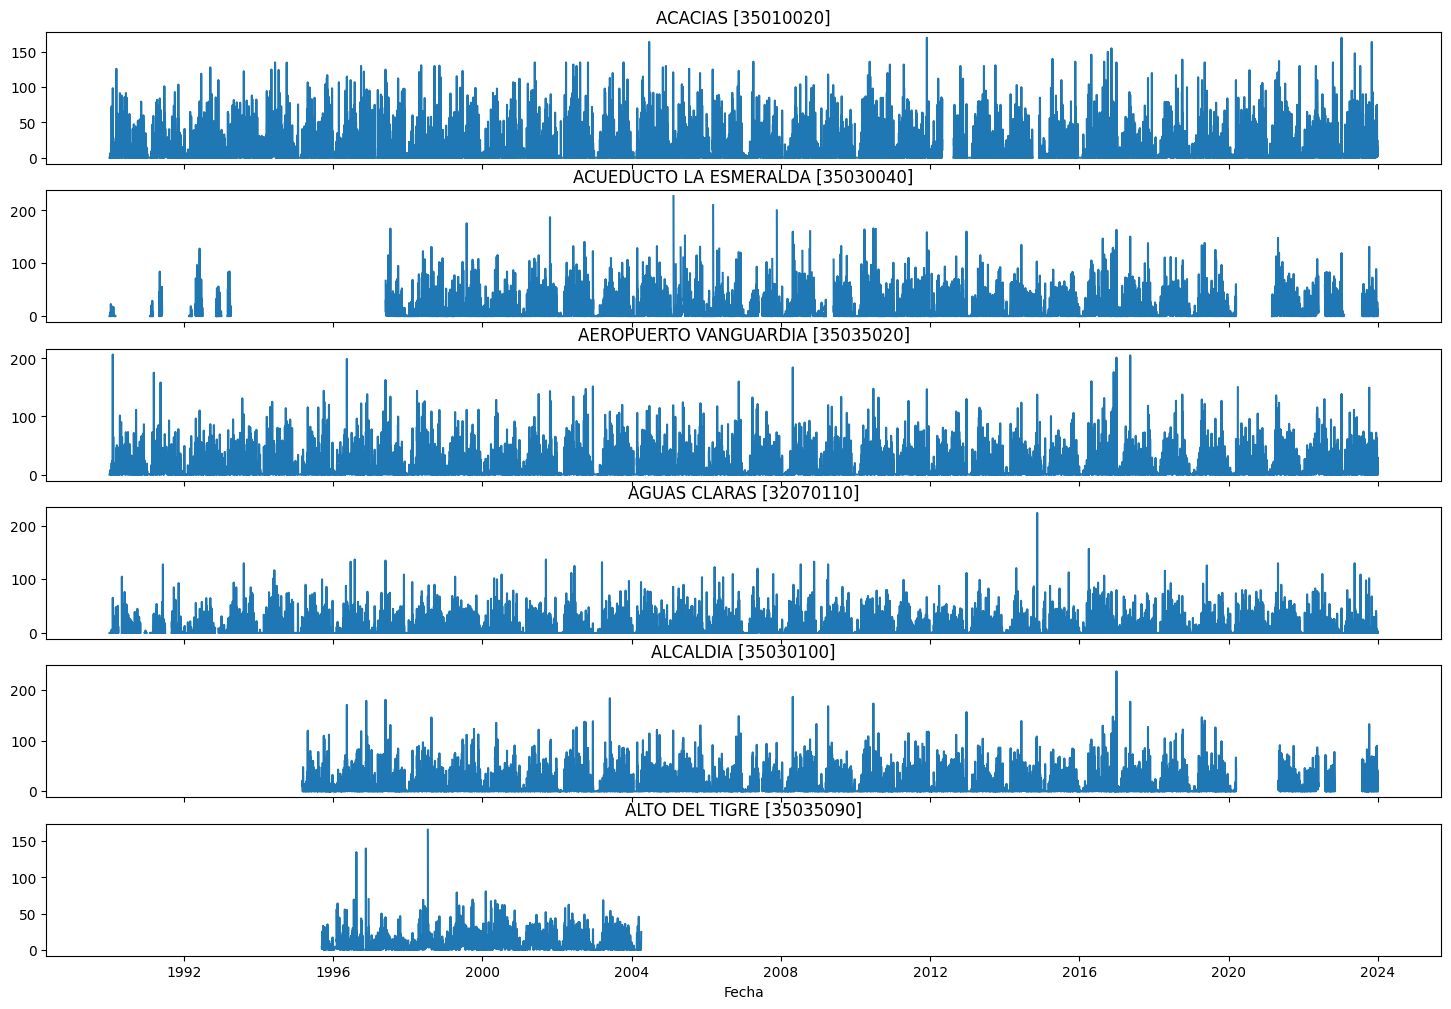

In [3]:
# Gráficar
# Selecciona todas las columnas de datos_estacion (presumiblemente un DataFrame)
# excepto la primera, que suele ser la columna de fechas, y asigna estas columnas a la variable 'estaciones'
estaciones = datos_estacion.columns[0:]
# Crea una figura y un conjunto de ejes utilizando subplots de matplotlib.
# El número de subplots se determina por la cantidad de estaciones.
# Se configura el tamaño de la figura en función del número de estaciones para que las gráficas no se superpongan.
# sharex=True comparte el mismo eje x entre todos los subplots.
fig, axs = plt.subplots(len(estaciones), 1, figsize=(18, len(estaciones)*2), sharex=True)
# Itera sobre el índice y el nombre de cada estación en la lista 'estaciones'
for i, estacion in enumerate(estaciones):
    # Grafica los datos de la estación actual en el subplot correspondiente
    axs[i].plot(datos_estacion.index, datos_estacion[estacion])
    # Configura el título del subplot con el nombre de la estación actual
    axs[i].set_title(estacion)
# Configura la etiqueta del eje x para toda la figura
plt.xlabel("Fecha")
# Muestra la figura con todos los subplots
plt.show()


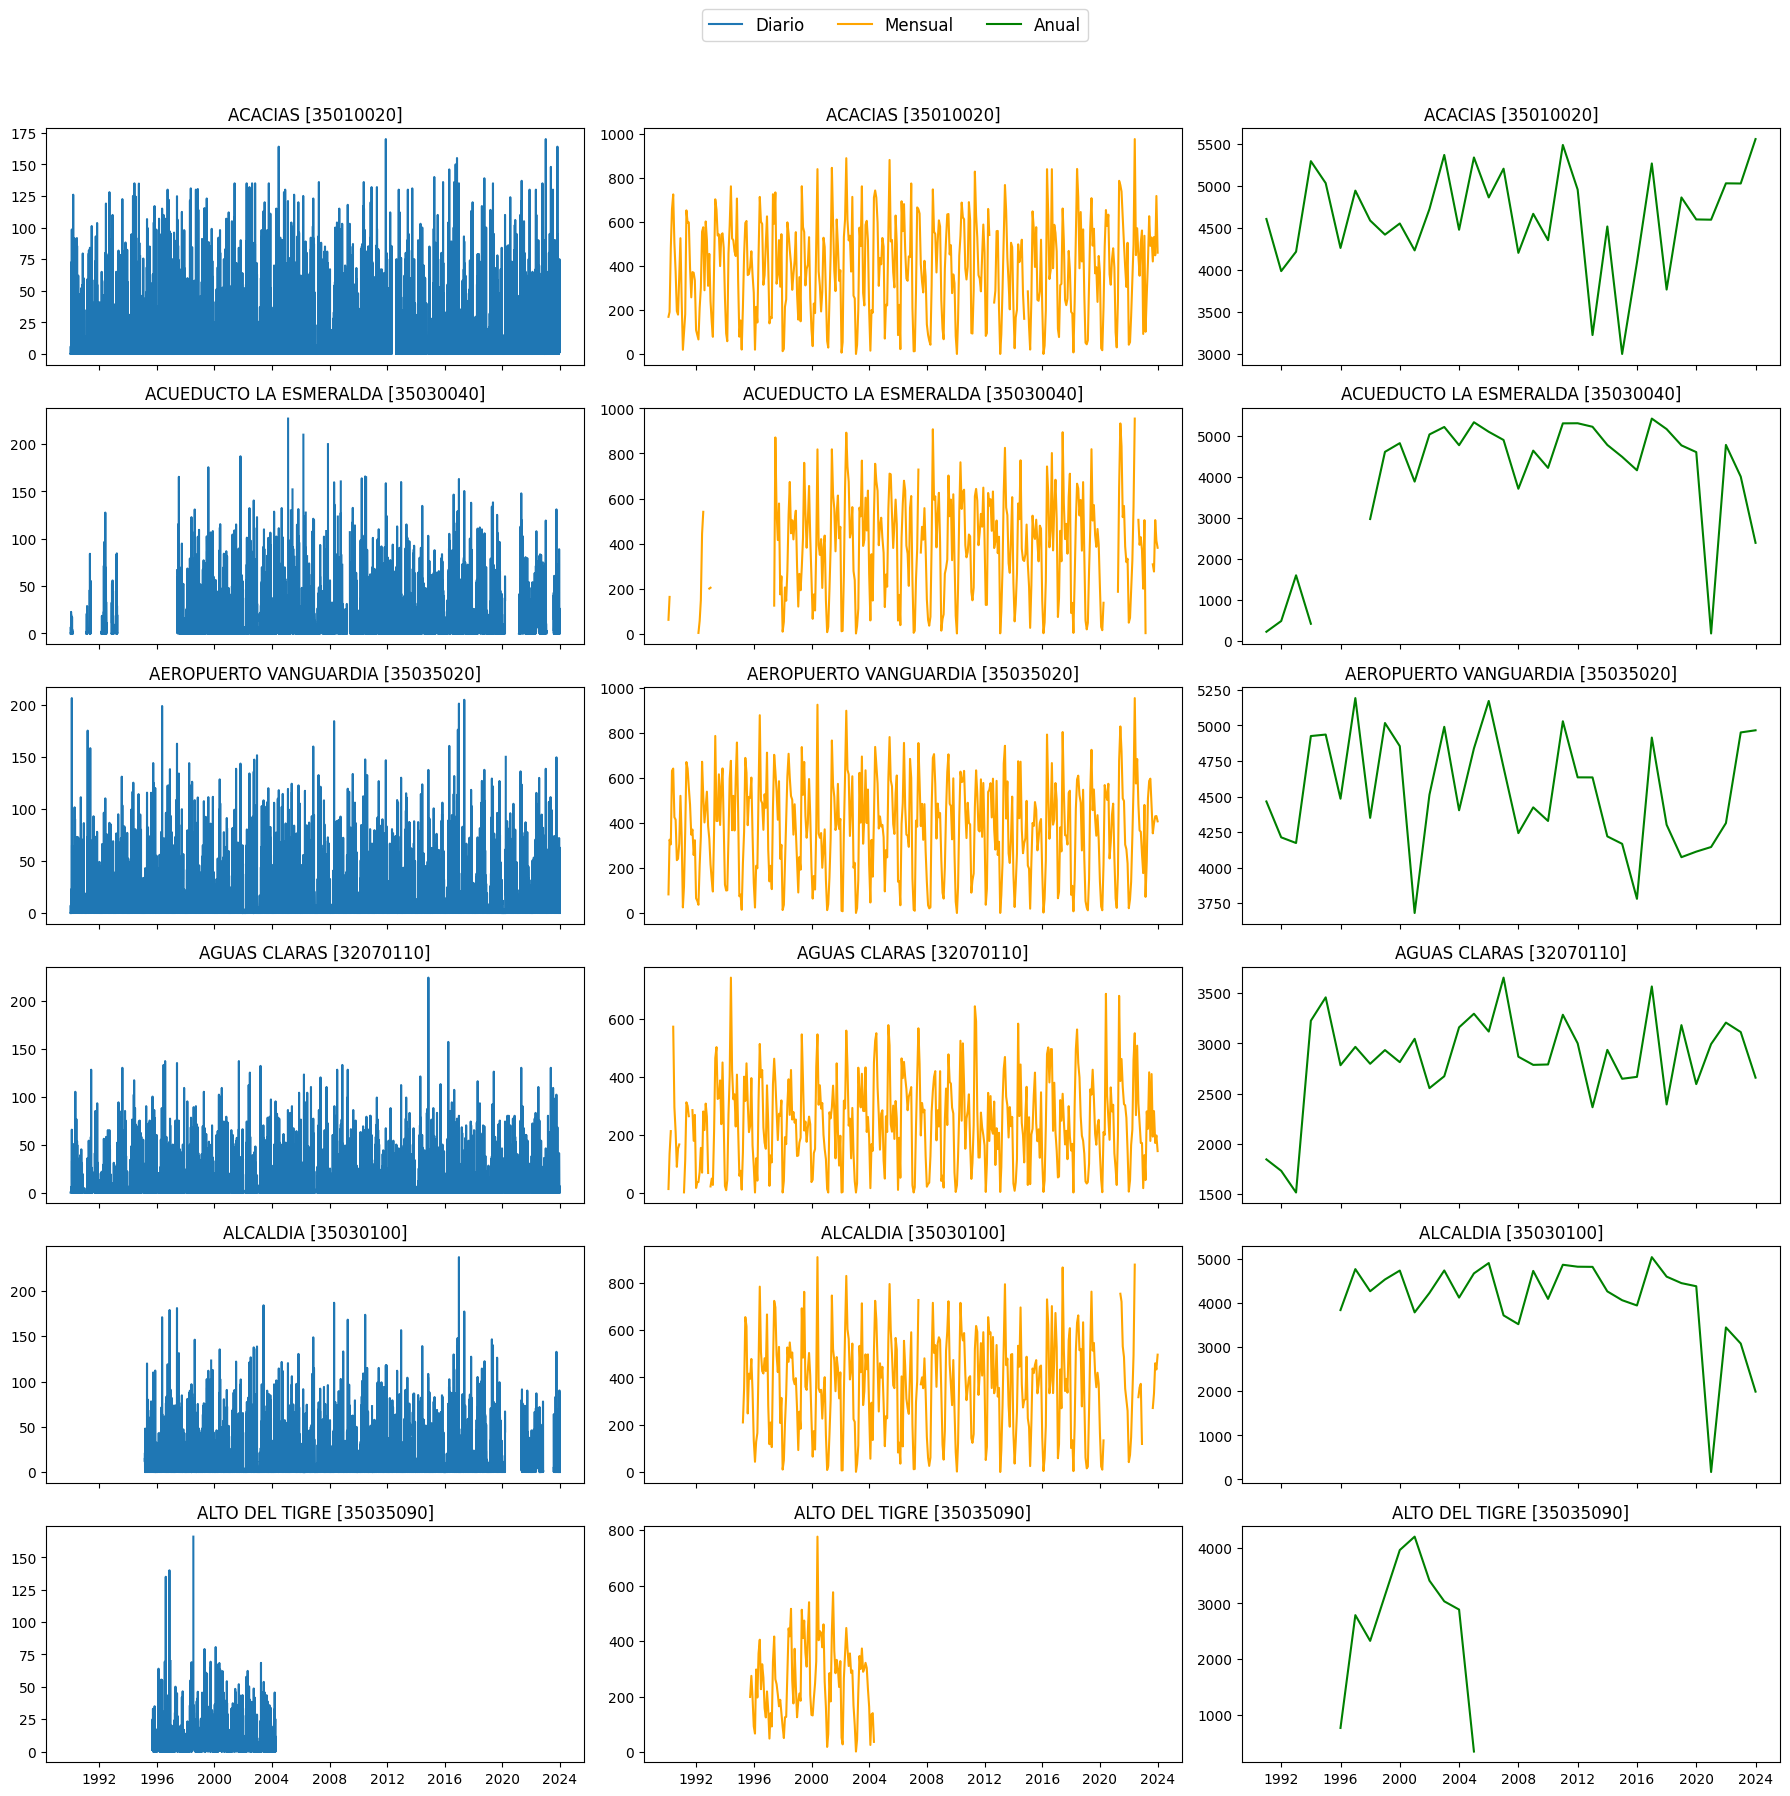

In [4]:
# Calcular las agregaciones mensuales y anuales para cada estación con min_count=1 para manejar NaN
datos_mensuales_con_nan = datos_estacion.resample('M').sum(min_count=1)
datos_anuales_con_nan = datos_estacion.resample('A').sum(min_count=1)

# Preparar la visualización ajustada para tener una única leyenda global
fig, axs = plt.subplots(len(datos_estacion.columns), 3, figsize=(18, len(datos_estacion.columns)*3), sharex='col')

# Crear marcadores para la leyenda única
markers = []
labels = ['Diario', 'Mensual', 'Anual']

for i, estacion in enumerate(datos_estacion.columns):
    # Datos diarios
    line1, = axs[i, 0].plot(datos_estacion.index, datos_estacion[estacion], label='Diario')
    axs[i, 0].set_title(estacion)

    # Datos mensuales con NaN
    line2, = axs[i, 1].plot(datos_mensuales_con_nan.index, datos_mensuales_con_nan[estacion], label='Mensual', color='orange')
    axs[i, 1].set_title(estacion)

    # Datos anuales con NaN
    line3, = axs[i, 2].plot(datos_anuales_con_nan.index, datos_anuales_con_nan[estacion], label='Anual', color='green')
    axs[i, 2].set_title(estacion)

    # Añadir los marcadores solo una vez
    if i == 0:
        markers.extend([line1, line2, line3])

# Colocar la leyenda fuera del área del gráfico con los marcadores
fig.legend(handles=markers, labels=labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=3, fontsize='large')

# Ajustar el espacio entre los gráficos y mostrar
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Ajustar el layout para acomodar la leyenda en la parte superior
plt.show()


In [5]:
# Especificar la ruta y el nombre del archivo de salida
output_file_path = 'datos_precipitacion.xlsx'

# Crear un escritor de Pandas Excel
with pd.ExcelWriter(output_file_path, engine='openpyxl') as writer:
    # Guardar cada DataFrame en una hoja diferente
    datos_estacion.to_excel(writer, sheet_name='Diarios')
    datos_mensuales_con_nan.to_excel(writer, sheet_name='Mensuales')
    datos_anuales_con_nan.to_excel(writer, sheet_name='Anuales')

# Indicar al usuario que la exportación ha sido completada y proporcionar la ruta del archivo
print(f"Los datos han sido exportados exitosamente a {output_file_path}")

Los datos han sido exportados exitosamente a datos_precipitacion.xlsx
